In [1]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
with open('raw.txt') as f:
    a = f.readlines()
a = list(map(lambda x:list(map(float,x.strip().split('   '))), a))
data = np.array(a)
del a

In [3]:
data = data[data[:, 0] < -546]

(array([83., 84., 91., 59., 19., 15.,  9., 11., 10.,  9.]),
 array([-546.84097098, -546.75763825, -546.67430551, -546.59097277,
        -546.50764003, -546.42430729, -546.34097455, -546.25764182,
        -546.17430908, -546.09097634, -546.0076436 ]),
 <BarContainer object of 10 artists>)

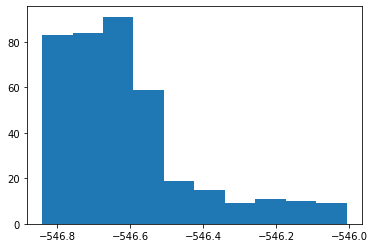

In [4]:
plt.hist(data[:, :1])

In [5]:
num_epochs = 10000
batch_size = 128
learning_rate = 0.01
random_seed = 14
best_model_path = './best_model.pth'

# 早停参数
patience = 100

# 定义MLP模型
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(X_train.shape[1], 32)
        self.output = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.sigmoid(self.hidden1(x))
        x = self.output(x)
        return x

Using device: cuda
Epoch [100/10000], Train Loss: 0.8730, Test Loss: 0.8334
Epoch [200/10000], Train Loss: 0.8246, Test Loss: 0.7648
Epoch [300/10000], Train Loss: 0.7529, Test Loss: 0.6736
Epoch [400/10000], Train Loss: 0.5829, Test Loss: 0.5185
Epoch [500/10000], Train Loss: 0.3533, Test Loss: 0.3405
Epoch [600/10000], Train Loss: 0.2491, Test Loss: 0.2571
Epoch [700/10000], Train Loss: 0.2092, Test Loss: 0.2304
Epoch [800/10000], Train Loss: 0.1855, Test Loss: 0.2187
Epoch [900/10000], Train Loss: 0.1647, Test Loss: 0.2086
Epoch [1000/10000], Train Loss: 0.1452, Test Loss: 0.1986
Epoch [1100/10000], Train Loss: 0.1278, Test Loss: 0.1890
Epoch [1200/10000], Train Loss: 0.1128, Test Loss: 0.1805
Epoch [1300/10000], Train Loss: 0.1015, Test Loss: 0.1749
Epoch [1400/10000], Train Loss: 0.0938, Test Loss: 0.1726
Epoch [1500/10000], Train Loss: 0.0879, Test Loss: 0.1710
Epoch [1600/10000], Train Loss: 0.0749, Test Loss: 0.1602
Epoch [1700/10000], Train Loss: 0.0543, Test Loss: 0.1339
Epoc

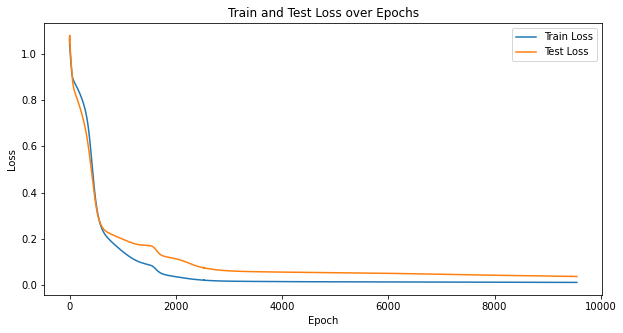

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 设置随机种子
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# 分割数据
X = data[:, 1:]
y = data[:, :1]

# 将数据集按 4:1 划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# 转换为 PyTorch 张量
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


# 对训练集的 y 进行标准化
y_mean = y_train.mean()
y_std = y_train.std()
y_train = (y_train - y_mean) / y_std

# 使用训练集的均值和标准差对测试集的 y 进行标准化
y_test = (y_test - y_mean) / y_std


# 检测是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 将数据移动到 GPU（如果可用）
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


# 实例化模型并移动到 GPU（如果可用）
model = MLP().to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型

num_batches = len(X_train) // batch_size
best_loss = float('inf')
trigger_times = 0

# 记录损失
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        inputs = X_train[start:end]
        targets = y_train[start:end]
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        epoch_loss += loss.item()
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    epoch_loss /= num_batches
    train_losses.append(epoch_loss)
    
    # 在测试集上进行评估
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test).item()
        test_losses.append(test_loss)
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    # 早停判断
    if test_loss < best_loss:
        best_loss = test_loss
        trigger_times = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch + 1}, best loss = {best_loss}')
            break


# 绘制损失函数图像
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss over Epochs')
plt.legend()
plt.show()


In [7]:
model.load_state_dict(torch.load(best_model_path))

model.eval()
y_test_true = np.array(y_test.cpu().reshape(-1))
y_test_pred = model(X_test).cpu().reshape(-1).detach().numpy()

y_train_true = np.array(y_train.cpu().reshape(-1))
y_train_pred = model(X_train).cpu().reshape(-1).detach().numpy()

In [8]:
pearsonr(y_test_pred, y_test_true)

(0.9858325905179567, 1.0889239568735352e-60)

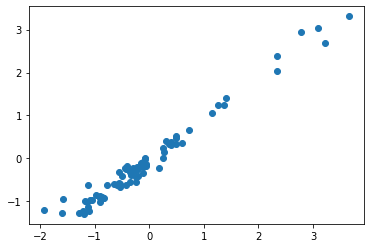

In [9]:
plt.scatter(y_test_pred[y_test_true<10], y_test_true[y_test_true<10])

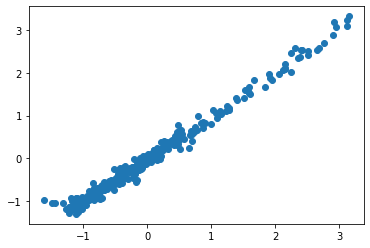

In [10]:
plt.scatter(y_train_pred[y_train_true<100], y_train_true[y_train_true<100])